# Get communities over k to match the indicative scatter and indicative inv plots

In [1]:
import numpy as np
import os
import json
import sys
import matplotlib.pyplot as plt
import skimage

sys.path.append("../")
import src.plot as myplot
import seaborn as sns

import sklearn

In [2]:
import importlib
import src.plot as myplot
importlib.reload(myplot)

<module 'src.plot' from '/Users/paulhosek/PycharmProjects/mcm/MCM_classifier/Classifier_1/mcm/paper_plots/../src/plot.py'>

In [3]:

import importlib
import src.paper_utils as utils
importlib.reload(utils)

<module 'src.paper_utils' from '/Users/paulhosek/PycharmProjects/mcm/MCM_classifier/Classifier_1/mcm/paper_plots/../src/paper_utils.py'>

In [4]:
sample_sizes = [10, 100, 500,1000, 2000, 3000,4000,5000]
sample_sizes = [1000]
counts_samplesizes, mcms_samplesizes = utils.load_counts_mcm(sample_sizes, letter="", path_format="../data/OUTPUT/mcm/sample_sizes")
test_mcms, test_probs = utils.get_complete_testprobs(mcms_samplesizes,counts_samplesizes,sample_sizes,n_runs=2,smooth=True)

In [5]:
sample_idx = 0
run_idx = 0
digit_pair = [0,1]
all_byk_pair, all_byk_modspin, all_comms, all_dists = utils.get_all_byk_pair(test_probs, test_mcms, digit_pair, sample_idx, run_idx, return_comms=True,return_dists=True)
all_byk_pair = utils.adjust_smaller_icc(all_byk_pair,all_byk_modspin)

In [6]:
def kmask(dists,comms, n_icc):
    """
    Return 2d binary mask of the k icc furthest from the decision boundary.
    dists = 1d np array of distances for each community. index refers to community label
    comms = 2d label np array of the communities
    """
    top_comms = np.argsort(dists)[-n_icc:]
    mask = np.isin(comms, top_comms).astype(int)
    return mask 

def modelled_pixel_map(all_dists, all_comms, n_icc):
    """Generated map to map the modelled pixels for each model into discrete sets.
    k is the index there (so should be k-1 as input if k is the number of rank of the icc). K is the number of modelled spins.

    Values in final map:
    1 = only by mod A
    2 = only by mod B
    3 = by both models 

    :param all_dists: _description_
    :type all_dists: _type_
    :param all_comms: _description_
    :type all_comms: _type_
    :param k: _description_
    :type k: _type_
    :return: _description_
    :rtype: _type_
    """
    
    out = kmask(all_dists[0], all_comms[0], n_icc) + kmask(all_dists[1], all_comms[1], n_icc)*2
    return out



In [7]:
# modelled_pixel_map(all_dists, all_comms,1)
import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap

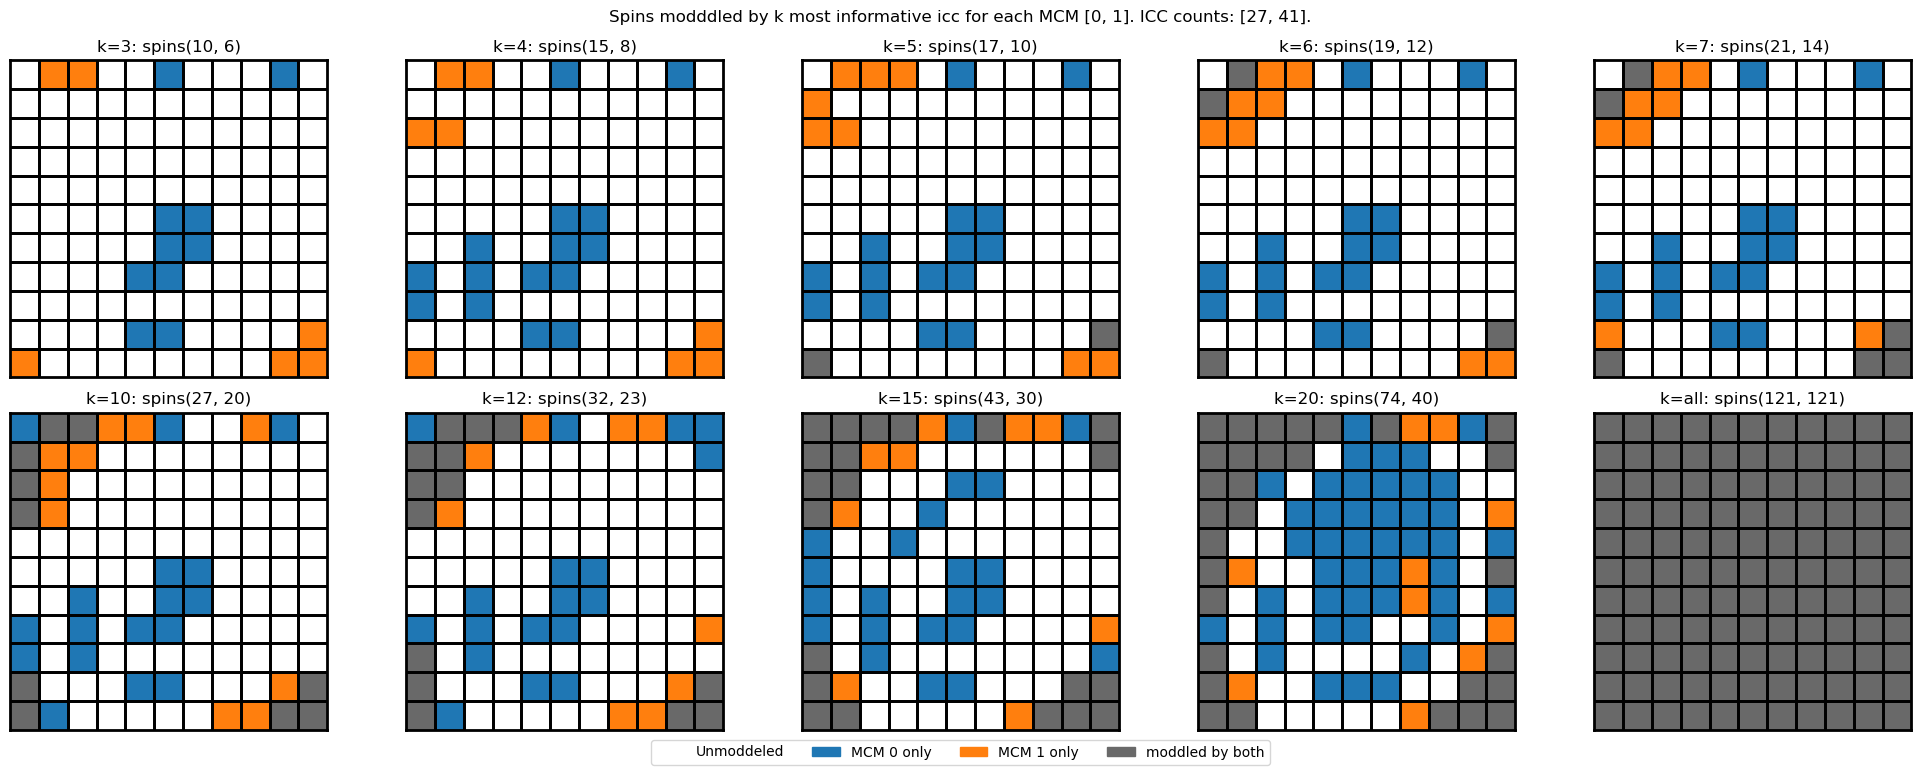

In [8]:
fig, axs = plt.subplots(2,5,figsize=(20,7.5))
axs = axs.ravel()
# len_shortest_mcm = np.min([len(i) for i in all_byk_pair])-1

top_ks = [3,4,5,6,7,
          10,12,15,20,0]

colors = myplot.get_default_colorcycle()
digit_colors = myplot.get_list_fromcmap("tab10", N=10)

colors = ['white', digit_colors[digit_pair[0]], digit_colors[digit_pair[1]], "dimgrey"] #7B4F6E
cmap = ListedColormap(colors)


for j, k in enumerate(top_ks):
    ax = axs[j]

    pix_map = modelled_pixel_map(all_dists,all_comms,k)
    im = myplot.partition_map(ax, pix_map, None,borders=myplot.find_borders(np.arange(121).reshape((11,11))),cmap=cmap,cbar=False, normalise=False, global_vbounds=(0,3))

    ax.set_title(f"k={k if k!=0 else 'all'}: spins{all_byk_modspin[0][k-1], all_byk_modspin[1][k-1]}")
    
# fig.supxlabel(f"Probablity g* MCM {digit_pair[0]}")
# fig.supylabel(f"Probability g* MCM {digit_pair[1]}")


labels = ["Unmoddeled", f"MCM {digit_pair[0]} only", f"MCM {digit_pair[1]} only", "moddled by both"]
handles = [mpatches.Patch(color=color, label=labels[i]) for i,color in enumerate(colors)]

fig.legend(handles=handles, bbox_to_anchor=(.5,-.01,0,0),ncol=4,loc="center")

# plt.legend(title="", bbox_to_anchor=(1.2,1,0,0))
fig.suptitle(f"Spins modddled by k most informative icc for each MCM {digit_pair}. ICC counts: {[len(i) for i in  all_byk_modspin]}.")
fig.tight_layout()



In [17]:
n_iccs = [len(np.unique(i)) for i in all_comms]

In [58]:

pix_map = modelled_pixel_map(all_dists,all_comms,k)

pix_sum_map = np.sum(np.array([modelled_pixel_map(all_dists,all_comms,k) for k in range(np.max(n_iccs))]),axis=0)

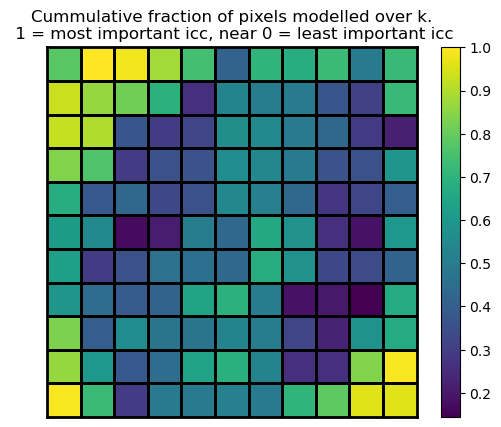

In [59]:
cmap = "viridis"
plt.title("Cummulative fraction of pixels modelled over k.\n 1 = most important icc, near 0 = least important icc")
myplot.partition_map(plt.gca(), pix_sum_map/pix_sum_map.max(), None,borders=myplot.find_borders(np.arange(121).reshape((11,11))),cmap=cmap,cbar=True, normalise=False)
